In [518]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max, cos, sin, pi, clone, sqrt, mean, std, sort, set_default_device, linspace, zeros, ones, rand
from scipy.constants import g



from dpfuncs import *

dev = 'cpu' 
set_default_device(dev)


#####
# problem setup

n_iterations = 100
lr = 5e-4

n_path_points = 100
t_min = 0
t_max = 1


h = (t_max - t_min)/n_path_points

m1 = tensor([1],dtype=torch.float)
l1 = tensor([1],dtype=torch.float)
m2 = tensor([1],dtype=torch.float)
l2 = tensor([10],dtype=torch.float)


path_t = linspace(t_min,t_max,n_path_points)
path_theta = zeros([2,n_path_points])
path_theta[:,0] = 2*(rand(2) - 0.5)
path_thetadot = 0.1*2*(rand([2,n_path_points]) - 0.5)

for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
        path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]

p_t_i = clone(path_theta)
p_td_i = clone(path_thetadot)


plt.show()

for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
        path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]

def trap_rule(data,h):
    n = data.shape[1]
    return h*( .5*(data[0] + data[-1]) + sum(data[1:-1]))

def S(L,theta,thetadot,h):
    density = Lv(theta,thetadot,m1,m2,l1,l2)
    return trap_rule(density,h)

def dS(L,theta,thetadot,h):
    grad_theta = jacrev(Lv,argnums=0)(theta,thetadot,m1,m2,l1,l2)
    grad_thetadot = jacrev(Lv,argnums=1)(theta,thetadot,m1,m2,l1,l2)
    return mean((grad_theta)**2 + (grad_thetadot)**2)

gt = jacrev(dS,argnums=1)
gtd = jacrev(dS,argnums=2)



100%|██████████| 750/750 [00:00<00:00, 6544.85it/s]


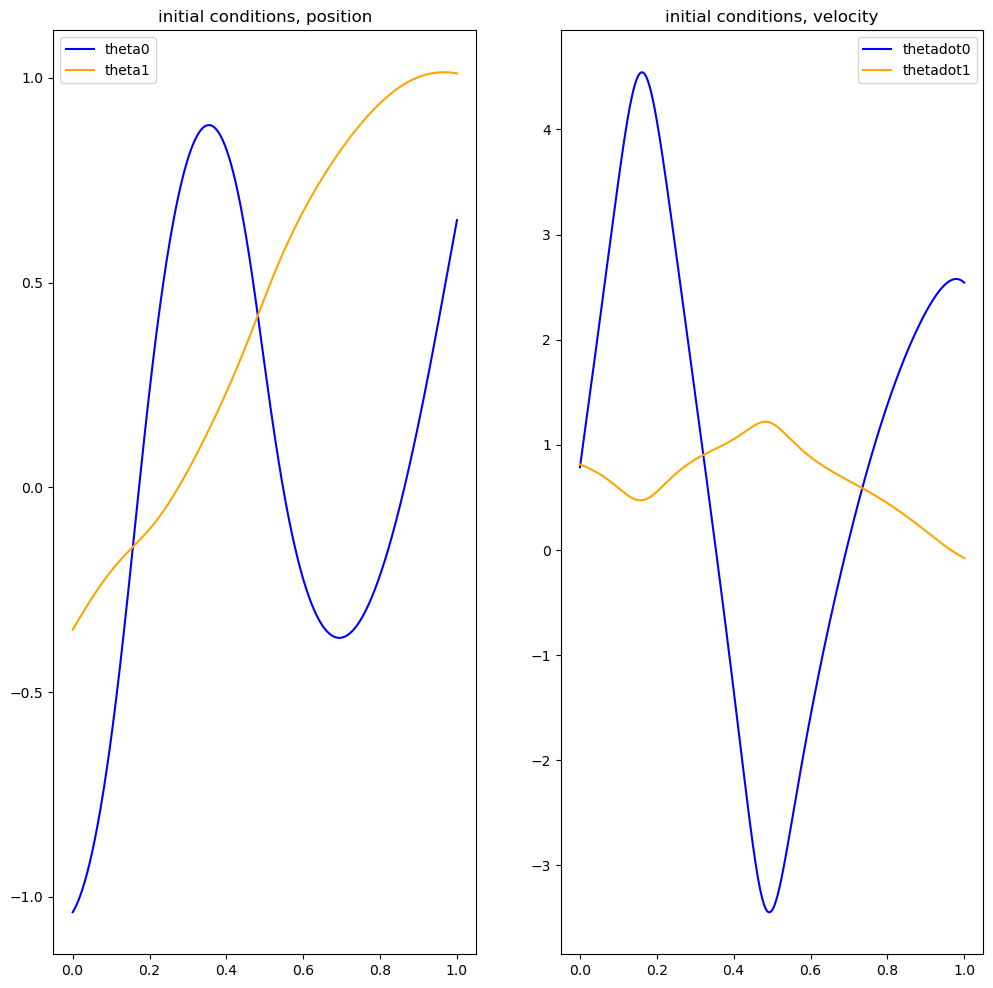

In [538]:
n_it = 750 #number of Euler steps
tmax = 2 #simulation time duration

random_initial_conditions = 1 #randomize t,tdot if == 1
path_t = linspace(t_min,t_max,n_it+1)

if random_initial_conditions == 1: #if random initial conditions:
    t = 1*pi*(torch.rand(2) - 0.5)
    tdot = 1*pi*(torch.rand(2) - 0.5)
else: #if specified initial conditions
    t = tensor([0,0],dtype=torch.float) 
    tdot = tensor([1.5,-.5],dtype=torch.float)

ttrue = clone(t) #clone out initial conditions for true tdd
tdottrue = clone(tdot)


h = tmax/n_it #calculate timestep

#initialize storage arrays
ttrue_arr = torch.zeros([n_it+1,2])
tdottrue_arr = torch.zeros([n_it+1,2])

iter_arr = torch.arange(0,n_it+1) #index array, for plotting

#copy initial conditions to storage array
ttrue_arr[0,:] = ttrue
tdottrue_arr[0,:] = tdottrue

#######################
# main calculation loop
for i in tqdm.trange(1,n_it+1): #iterate Euler steps

    #true tdd Euler step
    ttrue, tdottrue = Euler_step_true(ttrue,tdottrue,h,m1,m2,l1,l2)
    ttrue_arr[i,:] = ttrue.data#store new positions/velocities
    tdottrue_arr[i,:] = tdottrue.data

fig_i, axs_i = plt.subplots(1,2,figsize = (12,12))
axs_i[0].plot(path_t.detach().cpu(),ttrue_arr.detach().cpu().mT[0,:],color='blue',label='theta0')
axs_i[0].plot(path_t.detach().cpu(),ttrue_arr.detach().cpu().mT[1,:],color='orange',label='theta1')
axs_i[0].legend()
axs_i[0].set_title('initial conditions, position')

axs_i[1].plot(path_t.detach().cpu(),tdottrue_arr.detach().cpu().mT[0,:],color='blue',label='thetadot0')
axs_i[1].plot(path_t.detach().cpu(),tdottrue_arr.detach().cpu().mT[1,:],color='orange',label='thetadot1')
axs_i[1].legend()
axs_i[1].set_title('initial conditions, velocity')
plt.show()


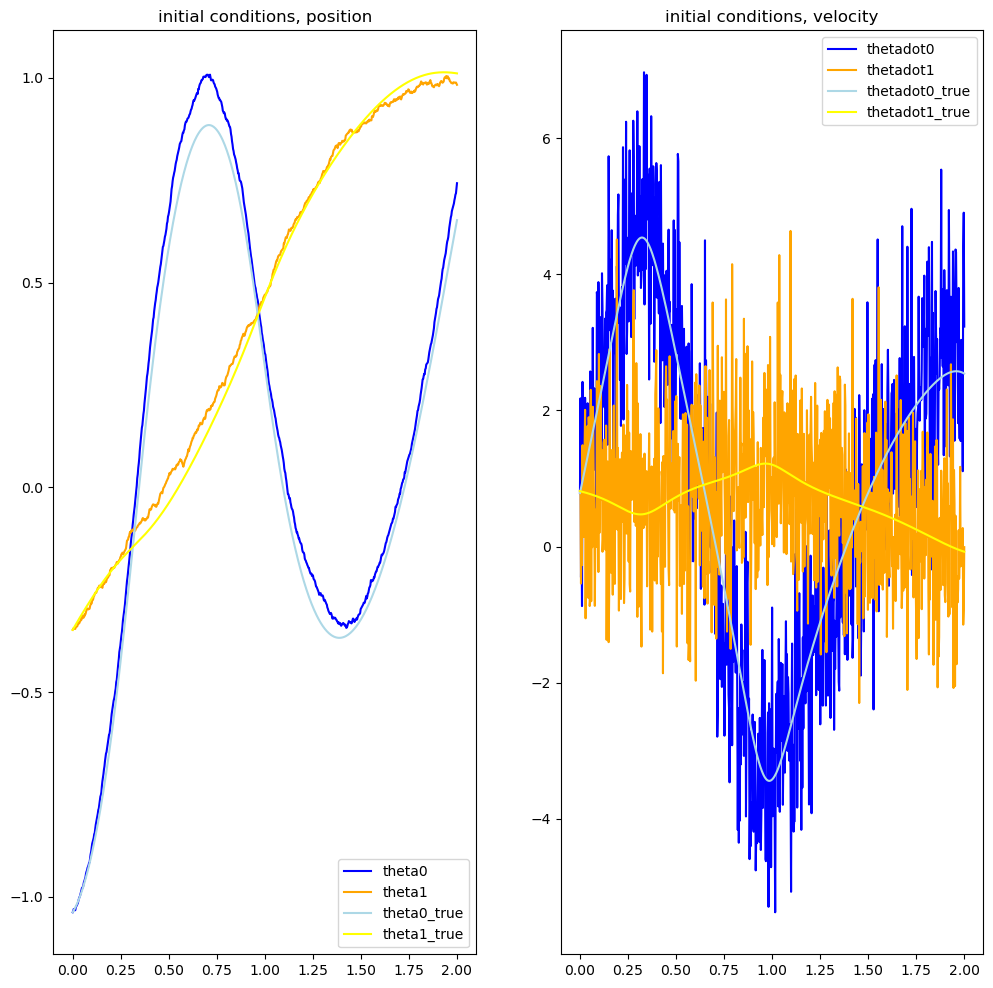

 97%|█████████▋| 6799/7000 [10:04<00:04, 44.64it/s]

In [ ]:
n_iterations = 7000
lr = 1e-4

noise_sigma = 1.125

n_path_points = n_it+1
t_min = 0
t_max = tmax
h = (t_max-t_min)/n_path_points

losses = torch.inf*torch.ones(n_iterations)

p_t_i = clone(ttrue_arr.mT)
p_td_i = clone(tdottrue_arr.mT)

path_t = linspace(t_min,t_max,n_path_points)
path_theta = clone(ttrue_arr.mT) + noise_sigma*torch.randn([2,n_path_points])
path_thetadot = clone(tdottrue_arr.mT) + noise_sigma*torch.randn([2,n_path_points])

path_theta[:,0] = p_t_i[:,0]
path_thetadot[:,0] = p_td_i[:,0]

for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
    path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]
#p_t_i = clone(path_theta)
#p_td_i = clone(path_thetadot)

p_t_noise = clone(path_theta)
p_td_noise = clone(path_thetadot)

fig_i, axs_i = plt.subplots(1,2,figsize = (12,12))
axs_i[0].plot(path_t.detach().cpu(),path_theta.detach().cpu()[0,:],color='blue',label='theta0')
axs_i[0].plot(path_t.detach().cpu(),path_theta.detach().cpu()[1,:],color='orange',label='theta1')
axs_i[0].plot(path_t.detach().cpu(),p_t_i[0,:].detach().cpu(),color='lightblue',label='theta0_true')
axs_i[0].plot(path_t.detach().cpu(),p_t_i[1,:].detach().cpu(),color='yellow',label='theta1_true')
axs_i[0].legend()
axs_i[0].set_title('initial conditions, position')

axs_i[1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_i[1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_i[1].plot(path_t.detach().cpu(),p_td_i[0,:].detach().cpu(),color='lightblue',label='thetadot0_true')
axs_i[1].plot(path_t.detach().cpu(),p_td_i[1,:].detach().cpu(),color='yellow',label='thetadot1_true')
axs_i[1].legend()
axs_i[1].set_title('initial conditions, velocity')
plt.show()

for i in tqdm.trange(n_iterations):
    loss = dS(L,path_theta,path_thetadot,h)
    if loss <= losses.min():
        #grad_theta = gt(L,path_theta,path_thetadot,h)#[0,:,:]
        grad_thetadot = gtd(Lv,path_theta,path_thetadot,h)#[0,:,:]
        #path_theta.data[:,1:] -= lr*grad_theta[:,1:]
        path_thetadot.data[:,1:] -= lr*grad_thetadot[:,1:]
        for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
            path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]
    losses[i] = loss

plt.plot(losses.detach().cpu())
plt.xlabel('iteration')
plt.ylabel('loss')
#plt.xscale('log')
# plt.yscale('log')
plt.show()

fig_f, axs_f = plt.subplots(2,2,figsize = (20,20))
axs_f[0,0].plot(path_t.detach().cpu(),path_theta[0,:].detach().cpu(),color='blue',label='theta0')
axs_f[0,0].plot(path_t.detach().cpu(),path_theta[1,:].detach().cpu(),color='orange',label='theta1')
axs_f[0,0].scatter(path_t.detach().cpu(),p_t_i[0,:].detach().cpu(),color='lightblue',label='theta0_true')
axs_f[0,0].scatter(path_t.detach().cpu(),p_t_i[1,:].detach().cpu(),color='yellow',label='theta1_true')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_noise[0,:].detach().cpu(),color='green',label='theta0_init')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_noise[1,:].detach().cpu(),color='red',label='theta1_init')
axs_f[0,0].legend()
axs_f[0,0].set_title('final conditions, position')

axs_f[0,1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[0,1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[0,1].scatter(path_t.detach().cpu(),p_td_i[0,:].detach().cpu(),color='lightblue',label='thetadot0_true')
axs_f[0,1].scatter(path_t.detach().cpu(),p_td_i[1,:].detach().cpu(),color='yellow',label='thetadot1_true')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_noise[0,:].detach().cpu(),color='green',label='theta0_init')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_noise[1,:].detach().cpu(),color='red',label='theta1_init')
axs_f[0,1].legend()
axs_f[0,1].set_title('final conditions, velocity')

axs_f[1,0].plot(path_t.detach().cpu(),path_theta[0,:].detach().cpu()-p_t_i[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[1,0].plot(path_t.detach().cpu(),path_theta[1,:].detach().cpu()-p_t_i[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[1,0].legend()
axs_f[1,0].set_title('dif, position')

axs_f[1,1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu()-p_td_i[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[1,1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu()-p_td_i[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[1,1].legend()
axs_f[1,1].set_title('dif, velocity')

plt.show()

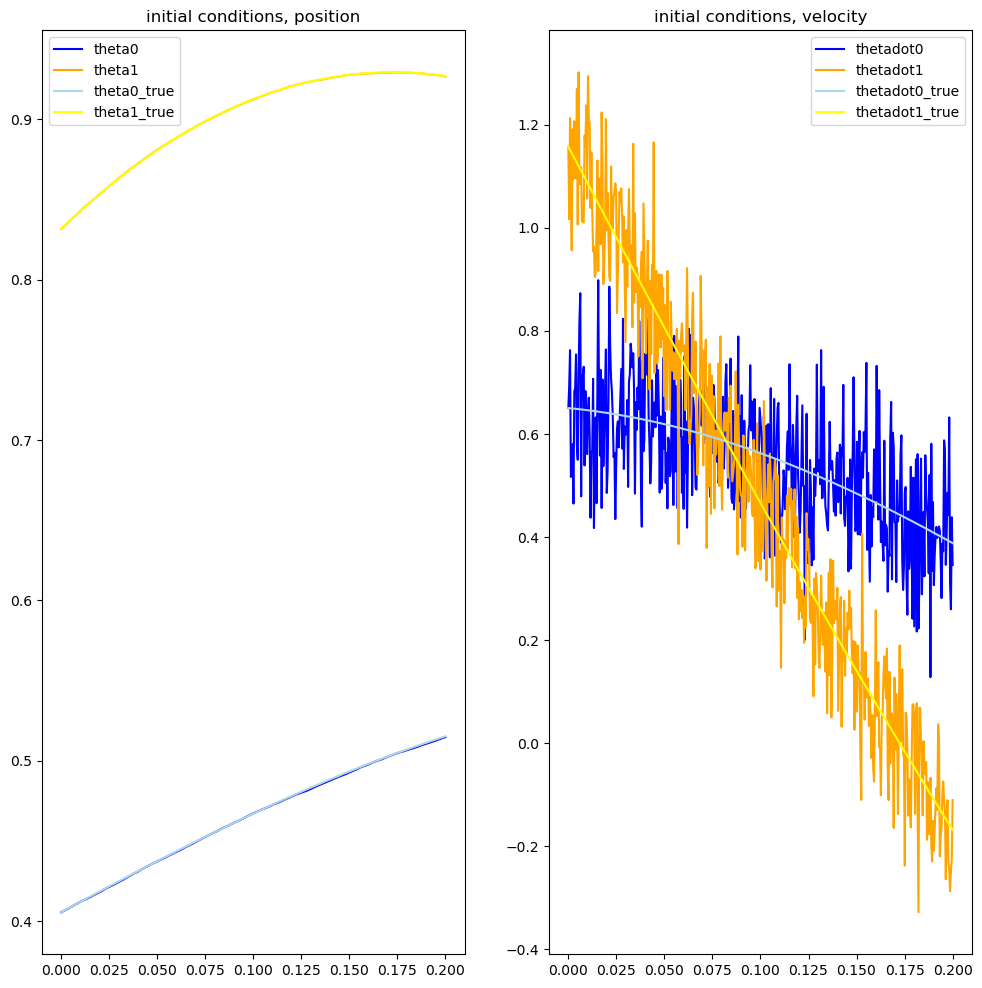

100%|██████████| 250/250 [00:05<00:00, 49.26it/s]


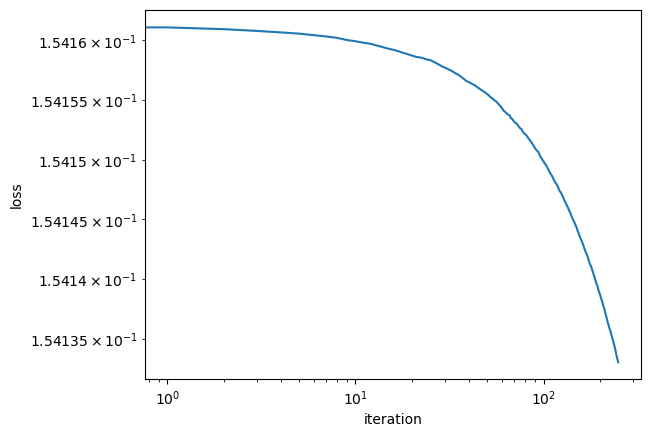

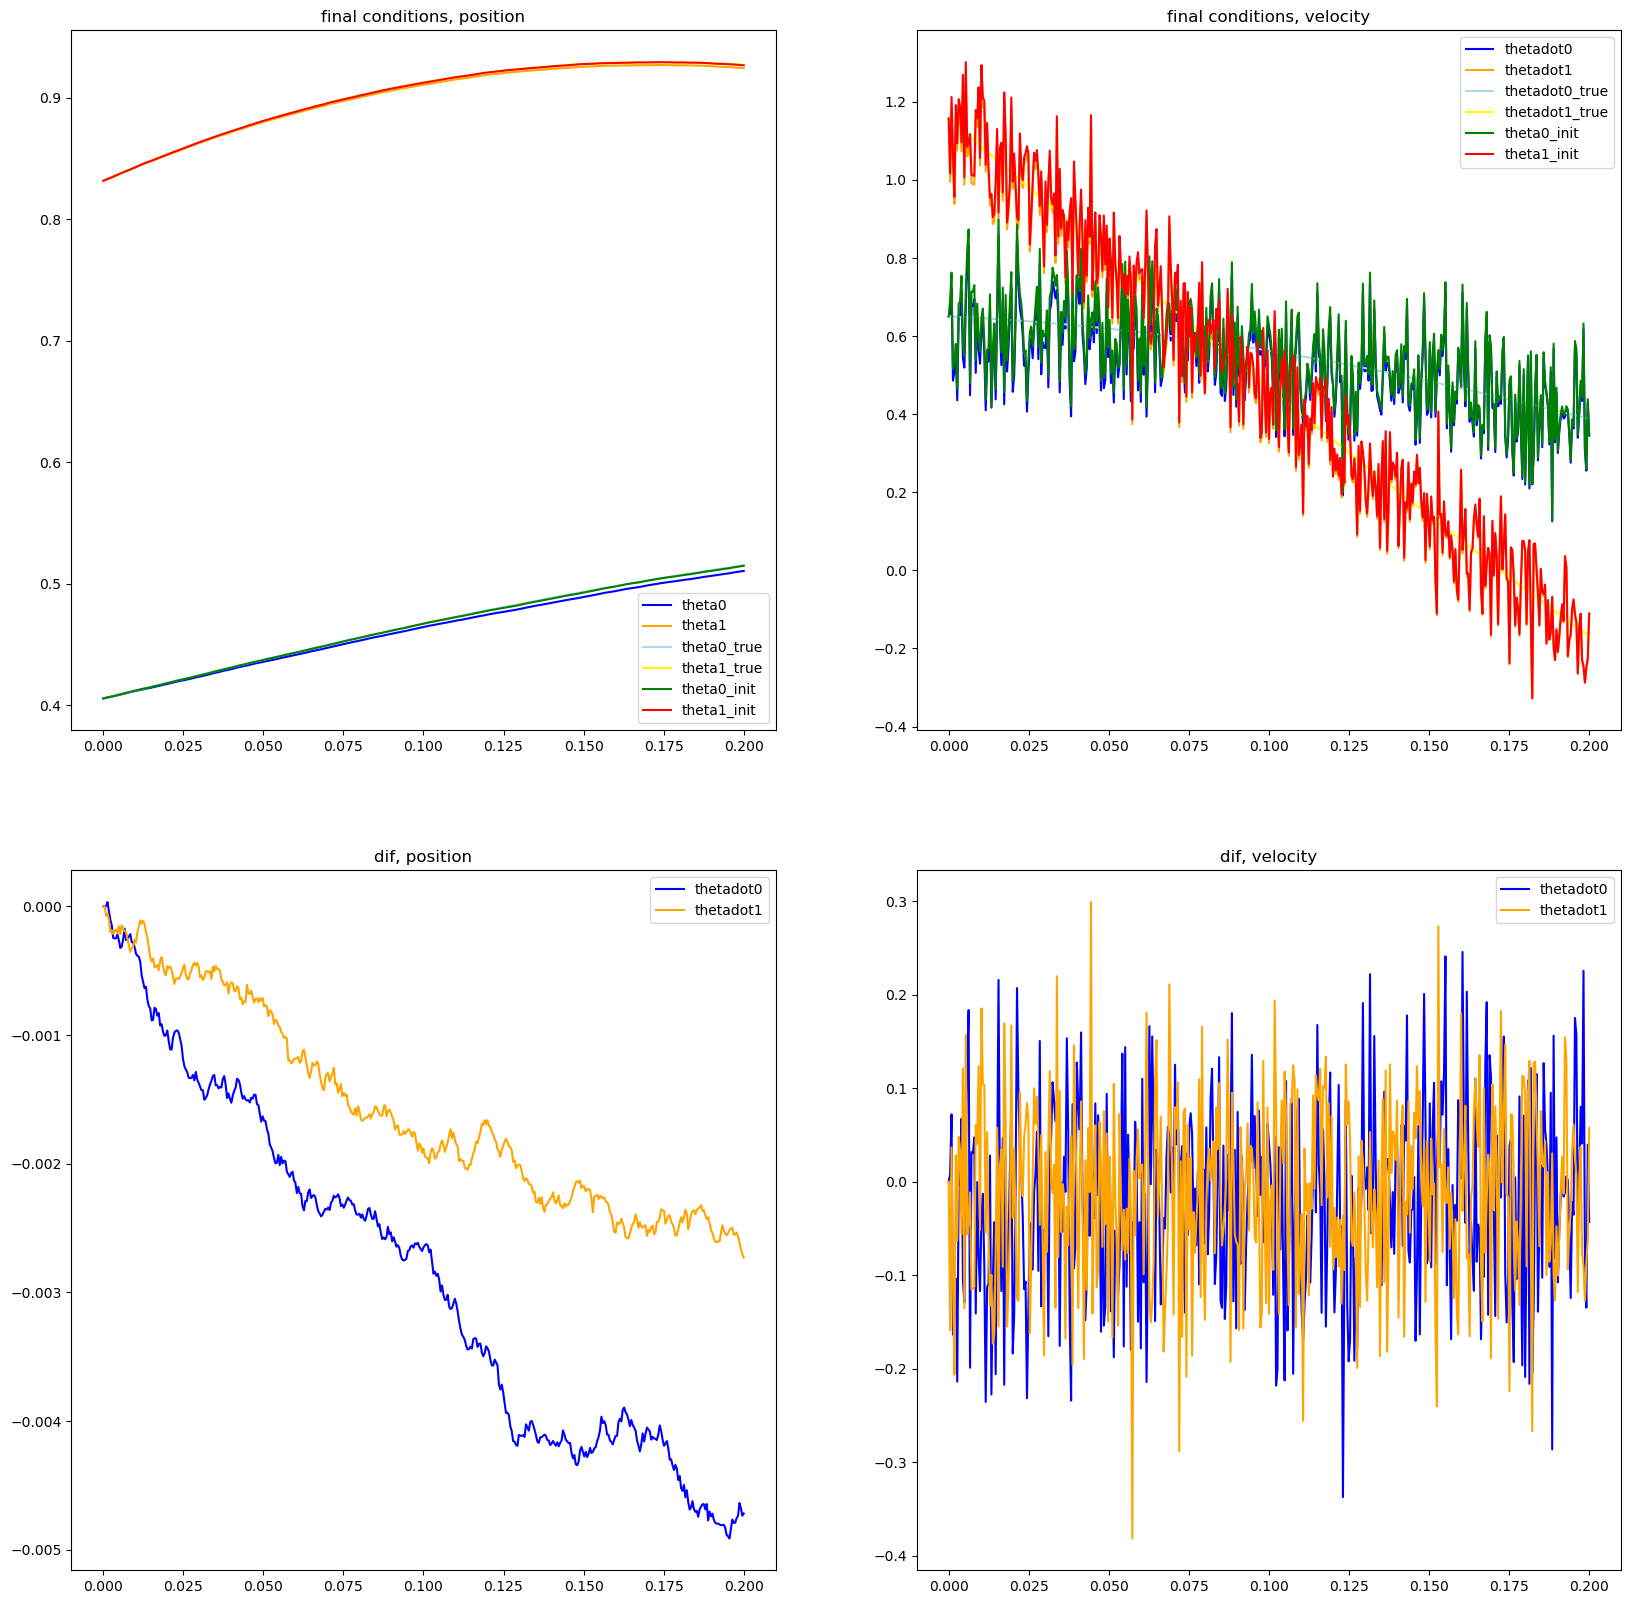

In [452]:
n_iterations = 250
lr = 1e-1
bl_lr = 5e0

n_blocks = 15

noise_sigma = 0.1

n_path_points = n_it+1

block_size = int(n_path_points/n_blocks)
t_min = 0
t_max = tmax
h = (t_max-t_min)/n_path_points

losses = torch.inf*torch.ones(n_iterations)

p_t_i = clone(ttrue_arr.mT)
p_td_i = clone(tdottrue_arr.mT)

path_t = linspace(t_min,t_max,n_path_points)
path_theta = clone(ttrue_arr.mT) + noise_sigma*torch.randn([2,n_path_points])
path_thetadot = clone(tdottrue_arr.mT) + noise_sigma*torch.randn([2,n_path_points])

path_theta[:,0] = p_t_i[:,0]
path_thetadot[:,0] = p_td_i[:,0]

for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
    path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]
#p_t_i = clone(path_theta)
#p_td_i = clone(path_thetadot)

p_t_noise = clone(path_theta)
p_td_noise = clone(path_thetadot)

fig_i, axs_i = plt.subplots(1,2,figsize = (12,12))
axs_i[0].plot(path_t.detach().cpu(),path_theta.detach().cpu()[0,:],color='blue',label='theta0')
axs_i[0].plot(path_t.detach().cpu(),path_theta.detach().cpu()[1,:],color='orange',label='theta1')
axs_i[0].plot(path_t.detach().cpu(),p_t_i[0,:].detach().cpu(),color='lightblue',label='theta0_true')
axs_i[0].plot(path_t.detach().cpu(),p_t_i[1,:].detach().cpu(),color='yellow',label='theta1_true')
axs_i[0].legend()
axs_i[0].set_title('initial conditions, position')

axs_i[1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_i[1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_i[1].plot(path_t.detach().cpu(),p_td_i[0,:].detach().cpu(),color='lightblue',label='thetadot0_true')
axs_i[1].plot(path_t.detach().cpu(),p_td_i[1,:].detach().cpu(),color='yellow',label='thetadot1_true')
axs_i[1].legend()
axs_i[1].set_title('initial conditions, velocity')
plt.show()

for i in tqdm.trange(n_iterations):
    for bl in range(n_blocks): #blocking update
        bl_theta = path_theta[:,bl*block_size:(bl+1)*block_size]
        bl_thetadot = path_thetadot[:,bl*block_size:(bl+1)*block_size]
        loss = dS(L,bl_theta,bl_thetadot,h)
        if loss <= losses.min():
            #grad_theta = gt(L,path_theta,path_thetadot,h)#[0,:,:]
            grad_thetadot = gtd(Lv,bl_theta,bl_thetadot,h)#[0,:,:]
            #path_theta.data[:,1:] -= lr*grad_theta[:,1:]
            path_thetadot.data[:,1+bl*block_size:(bl+1)*block_size] -= bl_lr*grad_thetadot[:,1:]
            for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
                path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]
    loss = dS(L,path_theta,path_thetadot,h) #full update
    if loss <= losses.min():
        #grad_theta = gt(L,path_theta,path_thetadot,h)#[0,:,:]
        grad_thetadot = gtd(Lv,path_theta,path_thetadot,h)#[0,:,:]
        #path_theta.data[:,1:] -= lr*grad_theta[:,1:]
        path_thetadot.data[:,1:] -= lr*grad_thetadot[:,1:]
        for j in range(1,n_path_points): #apply constraint that (d/dt)\theta = \dot{theta}
            path_theta[:,j] = path_theta[:,j-1] + h* path_thetadot[:,j-1]
    losses[i] = loss  
    

plt.plot(losses.detach().cpu())
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

fig_f, axs_f = plt.subplots(2,2,figsize = (20,20))
axs_f[0,0].plot(path_t.detach().cpu(),path_theta[0,:].detach().cpu(),color='blue',label='theta0')
axs_f[0,0].plot(path_t.detach().cpu(),path_theta[1,:].detach().cpu(),color='orange',label='theta1')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_i[0,:].detach().cpu(),color='lightblue',label='theta0_true')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_i[1,:].detach().cpu(),color='yellow',label='theta1_true')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_noise[0,:].detach().cpu(),color='green',label='theta0_init')
axs_f[0,0].plot(path_t.detach().cpu(),p_t_noise[1,:].detach().cpu(),color='red',label='theta1_init')
axs_f[0,0].legend()
axs_f[0,0].set_title('final conditions, position')

axs_f[0,1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[0,1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_i[0,:].detach().cpu(),color='lightblue',label='thetadot0_true')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_i[1,:].detach().cpu(),color='yellow',label='thetadot1_true')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_noise[0,:].detach().cpu(),color='green',label='theta0_init')
axs_f[0,1].plot(path_t.detach().cpu(),p_td_noise[1,:].detach().cpu(),color='red',label='theta1_init')
axs_f[0,1].legend()
axs_f[0,1].set_title('final conditions, velocity')

axs_f[1,0].plot(path_t.detach().cpu(),path_theta[0,:].detach().cpu()-p_t_i[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[1,0].plot(path_t.detach().cpu(),path_theta[1,:].detach().cpu()-p_t_i[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[1,0].legend()
axs_f[1,0].set_title('dif, position')

axs_f[1,1].plot(path_t.detach().cpu(),path_thetadot[0,:].detach().cpu()-p_td_i[0,:].detach().cpu(),color='blue',label='thetadot0')
axs_f[1,1].plot(path_t.detach().cpu(),path_thetadot[1,:].detach().cpu()-p_td_i[1,:].detach().cpu(),color='orange',label='thetadot1')
axs_f[1,1].legend()
axs_f[1,1].set_title('dif, velocity')

plt.show()